# Light GBM Model
#### cv score :  0.5502911153119092 (5 folds, tgt enc)
#### cv score :  0.5534669187145557 (5fold)
#### cv score :  0.5534489970795226 (5 even fold)
#### cv score :  0.5507674858223063   (10 folds)
#### cv score :  0.5539240004577335   (5 even folds, nomizumahi)

In [13]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import sklearn
from Functions import prepro
import warnings

import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')
import lightgbm as lgb
from lightgbm import LGBMClassifier


FEATURE_SELECTION = False

random.seed(0)

pd.set_option("display.max_columns", 600)
pd.set_option("display.max_rows", 600)


In [2]:
train_df = pd.read_csv("../../data/Processed/train2.csv")
test_df = pd.read_csv("../../data/Processed/test2.csv")
print(train_df.shape)
print(test_df.shape)

(66125, 192)
(28340, 191)


In [3]:
y = train_df["y"].values
train_df = train_df.drop("y", axis=1)

In [4]:
# add disconnection info

train_df = prepro.add_disconnection(train_df)
test_df = prepro.add_disconnection(test_df)

In [5]:
# add info about numeric column
# 武器データの中のnum_colsを持つ特徴について、チーム内の統計量を計算、levelは結構効いてる

num_cols = ["level", "range", "rapid-", "atack", "ink-sub", "fav-main", "good-special"]

#train_df = prepro.flat(train_df, num_cols)
#test_df = prepro.flat(test_df, num_cols)

train_df = prepro.add_numeric_info(train_df, num_cols)
test_df = prepro.add_numeric_info(test_df, num_cols)

# 欠損値埋め先にやろう
欠損値がある列

rank, weapon, level ⇨　回線切れ or ナワバリ

weaponの欠損に並んでそれに関係ある列、A3, A4, B3, B4 ⇨ 回線切れ

level, weaponが消えていたら回線切れ

In [6]:
# rankの欠損値を埋める
train_df, test_df = prepro.fillna_rank(train_df, test_df)

#そのほかの欠損値を埋める
train_df, test_df = prepro.fillna(train_df, test_df)

In [7]:
print(train_df.isnull().sum().sum())
print(test_df.isnull().sum().sum())

0
0


# 特徴量エンジニアリング


In [8]:
# count reskin, by mode
print("reskin")
train_df, test_df = prepro.count_reskin(train_df, test_df)
train_df, test_df = prepro.count_reskin_by_mode(train_df, test_df)

# count mainweapon, by mode
print("mainweapon")
train_df, test_df = prepro.count_mainweapon(train_df, test_df)
train_df, test_df = prepro.count_mainweapon_by_mode(train_df, test_df)

# count subweapon, by mode
print("subweapon")
train_df, test_df = prepro.count_subweapon(train_df, test_df)
train_df, test_df = prepro.count_subweapon_by_mode(train_df, test_df)

# count special, by mode
print("special")
train_df, test_df = prepro.count_special(train_df, test_df)
train_df, test_df = prepro.count_special_by_mode(train_df, test_df)

#identify A1
train_df, test_df = prepro.identify_A1(train_df, test_df)


# 水増し, A1も統計量に含めた特徴を作る場合は水ましより先にやる
train_df, y = prepro.mizumashi(train_df, y)

# is_nawabari
train_df, test_df = prepro.is_nawabari(train_df, test_df)

# match rank
train_df, test_df = prepro.match_rank(train_df, test_df)



reskin
mainweapon
subweapon
special


In [9]:
# add team info

train_df,  test_df = prepro.addTeamInfo(train_df, test_df, cols=["special", "subweapon", "category1", "category2", "mainweapon"])

(160590, 344)
special-A
special-B
subweapon-A
subweapon-B
category1-A
category1-B
category2-A
category2-B
mainweapon-A
mainweapon-B
(160590, 538)
complete


In [10]:
# categorize team

categorize_col = ["category1", "category2", "subweapon", "special", "mainweapon"]
for col in categorize_col:
    print(col)
    train_df_, test_df_ = prepro.categorize_team(train_df, test_df, col)

category1
category2
subweapon
special
mainweapon


In [11]:
# product categorical feature
train_df, test_df = prepro.prod(train_df, test_df, "mode", "stage")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category1-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category1-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category2-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category2-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-mainweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-mainweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-subweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-subweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-special-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-special-B")

train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category1-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category1-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category2-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category2-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-mainweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-mainweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-subweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-subweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-special-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-special-B")

In [12]:
# make input

drop_cols = ["id", "lobby", "lobby-mode",  "period", "game-ver", "A1-weapon", "A2-weapon", "A3-weapon", "A4-weapon", \
              "B1-weapon", "B2-weapon", "B3-weapon", "B4-weapon"]

categorical_feature = [col for col in train_df.dtypes[train_df.dtypes == "object"].index.to_list() if col not in drop_cols]

X, test_X = prepro.make_input(train_df, test_df, drop_cols, categorical_encode=True, scaler=False, verbose=False)

complete


# 特徴選択

In [14]:
if FEATURE_SELECTION:
    from sklearn.ensemble import RandomForestClassifier

    clf = RandomForestClassifier()
    clf.fit(X, y)
    importance = pd.DataFrame(clf.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
    display(importance*10000)
    use_cols = importance.index[:450]
else:
    print("No feature selection")


No feature selection


# モデル学習

In [23]:
# 全データを5つに分割
random.seed(random.randint(0, 10000))
SIZE = X.shape[0]
K = 5
cat_tgtenc_cols = ["mode", "stage", "team-category1-A", "team-category1-B"]
#cat_tgtenc_cols = ["mode", "stage"]

# folds = prepro.make_kfolds(SIZE, K)
#folds = prepro.make_stratified_kfolds(X, y, K)
folds = prepro.make_even_kfolds(X, y, K)

print(len(folds))
for i, fold in enumerate(folds):
    print("fold ", i+1, " size is ", len(fold))
    
    
if SIZE != len(set(sum(folds, []))):
    print("error is occuring in spliting")
else :
    print("successfully split")
    
# 
#X = X[use_cols]
#test_X = test_X[use_cols]

5
fold  1  size is  26362
fold  2  size is  26362
fold  3  size is  26362
fold  4  size is  26362
fold  5  size is  26802
successfully split


In [24]:
param = {
    "num_leaves" : 28,
    "learning_rate" : 0.01,
    #"learning_rate" : 0.05,
    "num_iterations" : 2000,
    "objective" : "binary",
    "metric" : ["binary_logloss"],
    "random_state" : random.randint(0, 10000),
    "max_depth" : 100
}

THRESHOLD = 0.50
models = []
cv_scores = []
temp = 0
train_pred = []
train_Xs = []
tgt_encode = False

all_indices = sum(folds, [])
for i in range(K):
    print("======================== fold {} ========================".format(i+1))
    valid_indices = folds[i]
    train_indices = list(set(all_indices) - set(valid_indices))
    # print("train ", len(train_indices), " , valid ", len(valid_indices))
    train_X = X.iloc[train_indices]
    try:
        train_y = y.iloc[train_indices]
    except:
        train_y = y[train_indices]
    valid_X = X.iloc[valid_indices]
    try:
        valid_y = y.iloc[valid_indices]
    except:
        valid_y = y[valid_indices]
    
    
    if tgt_encode:
        for col in cat_tgtenc_cols:
            print(col)
            train_X, valid_X = prepro.target_encoding(train_X, valid_X, train_y, col, "y")
        
    train_Xs.append(train_X)
    
    train_data = lgb.Dataset(train_X, label=train_y)
    valid_data = lgb.Dataset(valid_X, label=valid_y)
    
    model = lgb.train(
        param, 
        train_data, 
        valid_sets=valid_data, 
        #categorical_feature=categorical_feature,
        early_stopping_rounds=40, 
        verbose_eval=100,
        
    )
    pred = model.predict(valid_X)
    pred = np.where(pred < THRESHOLD, 0, 1)
    train_pred.append(pred)
    temp += np.sum(pred)
    
    score = accuracy_score(pred, valid_y)
    
    models.append(model)
    cv_scores.append(score)
    
    
print("cv score : ", np.mean(cv_scores))    
print("cv ratio : ", temp / SIZE)

======================== fold 1 ========================
Training until validation scores don't improve for 40 rounds
[100]	valid_0's binary_logloss: 0.688224
[200]	valid_0's binary_logloss: 0.685862
[300]	valid_0's binary_logloss: 0.684562
[400]	valid_0's binary_logloss: 0.683884
[500]	valid_0's binary_logloss: 0.683492
[600]	valid_0's binary_logloss: 0.68324
[700]	valid_0's binary_logloss: 0.683158
[800]	valid_0's binary_logloss: 0.68302
[900]	valid_0's binary_logloss: 0.682917
[1000]	valid_0's binary_logloss: 0.682861
Early stopping, best iteration is:
[999]	valid_0's binary_logloss: 0.68286
======================== fold 2 ========================
Training until validation scores don't improve for 40 rounds
[100]	valid_0's binary_logloss: 0.687562
[200]	valid_0's binary_logloss: 0.68469
[300]	valid_0's binary_logloss: 0.683101
[400]	valid_0's binary_logloss: 0.682113
[500]	valid_0's binary_logloss: 0.681576
[600]	valid_0's binary_logloss: 0.681237
[700]	valid_0's binary_logloss: 0.6

0.510392270254233
0.5110223735667266
0.510641576261992
0.5108520655417458
0.510367102506563
0.5106550776262522


array([[<AxesSubplot:title={'center':'pred'}>]], dtype=object)

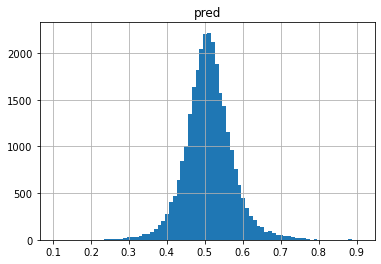

In [27]:
preds = []
if tgt_encode:
    for col in cat_tgtenc_cols:
        print(col)
        X, test_X = prepro.target_encoding(X, test_X, y, col, "y")

for i in range(K):
    model = models[i]
    pred = model.predict(test_X)
    preds.append(pred)
    print(np.sum(pred) / pred.shape[0])
    
preds = np.array(preds)
preds = np.mean(preds, axis=0)
print(np.sum(preds) / preds.shape[0])


temp = pd.DataFrame({"pred":pred})
temp.hist(bins=80)

In [26]:
preds = np.where(preds < THRESHOLD, 0, 1)
print(np.sum(preds) / preds.shape[0])

submit_df = pd.DataFrame({'y': preds})
submit_df.index.name = 'id'
#submit_df.to_csv('../Submissions/submission10_{}.csv'.format(K))

0.5761115031757233


# モデル解釈

In [32]:
importance = pd.DataFrame(models[1].feature_importance(), index=train_Xs[0].columns, columns=['importance']).sort_values('importance', ascending=False)
display(importance.iloc[:100])

,importance
A-level-median,646
B-level-median,561
A1-level,427
B1-level,420
team-category2-A,396
team-category2-B,391
B2-level,324
B-level-min,315
A2-level,298
A-level-min,295


In [37]:
indices = [index for index in importance.index if "reskin" in index or "mainweapon" in index]
importance.loc[indices]

,importance
reskin-A1-count-by-mode,268
mainweapon-A2-count-by-mode,213
reskin-B1-count-by-mode,200
mainweapon-B2-count-by-mode,182
reskin-A3-count,180
reskin-B1-count,162
reskin-B2-count-by-mode,158
reskin-A2-count-by-mode,150
mainweapon-A1-count-by-mode,148
reskin-B4-count,142


In [ ]:
importance["importance"].sum()

In [ ]:
print(train_df[train_df["pred"] == train_df["y"]].shape[0] / train_df.shape[0])
train_df["pred"] = 0
train_df["y"] = y
for i in range(K):
    train_df["pred"].iloc[folds[i]] = train_pred[i]
for mode in train_df["mode"].unique():
    rate = train_df[train_df["mode"] == mode][train_df["pred"] == train_df["y"]].shape[0] / train_df[train_df["mode"] == mode].shape[0]
    print("{} : {}".format(mode, rate))

In [ ]:
result_df = train_df[train_df["y"] != train_df["pred"]]

In [ ]:
print(train_df[train_df["mode"] == "nawabari"].shape[0]/train_df.shape[0])
print(train_df[train_df["mode"] == "hoko"].shape[0]/train_df.shape[0])
print(train_df[train_df["mode"] == "asari"].shape[0]/train_df.shape[0])
print(train_df[train_df["mode"] == "area"].shape[0]/train_df.shape[0])
print(train_df[train_df["mode"] == "yagura"].shape[0]/train_df.shape[0])

In [ ]:
print(result_df[result_df["mode"] == "nawabari"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "hoko"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "asari"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "area"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "yagura"].shape[0]/result_df.shape[0])

In [ ]:
result_df.loc[:100]

In [ ]:
X

In [34]:
train_df["atack-main-A1"]

1         45
2         65
3         22
4         90
5         52
          ..
132246    52
132247    28
132248    45
132249    22
132250    35
Name: atack-main-A1, Length: 132250, dtype: int64

In [33]:
train_df["rapid-main-A1"]

1         60
2         60
3         75
4         80
5         75
          ..
132246    75
132247    49
132248    55
132249    75
132250    30
Name: rapid-main-A1, Length: 132250, dtype: int64

In [35]:
train_df["rapid-main-A1"] * train_df["atack-main-A1"]

1         2700
2         3900
3         1650
4         7200
5         3900
          ... 
132246    3900
132247    1372
132248    2475
132249    1650
132250    1050
Length: 132250, dtype: int64

In [44]:
train_df["mainweapon-A1"].unique()

array(['sshooter', 'parashelter', 'nzap85', 'bamboo14mk1', 'bold',
       'dualsweeper', 'splatspinner', 'prime', 'barrelspinner', 'rapid',
       'squiclean_a', 'hydra', 'hissen', 'splatcharger', 'splatroller',
       'screwslosher', 'l3reelgun', 'furo', 'carbon', 'hokusai',
       'sputtery', 'wakaba', 'bucketslosher', 'kugelschreiber', 'dynamo',
       'maneuver', 'nova', 'sharp', 'liter4k', 'kelvin525', 'explosher',
       'promodeler_mg', 'h3reelgun', 'jetsweeper', '96gal',
       'bottlegeyser', 'variableroller', 'rapid_elite', 'nautilus47',
       'campingshelter', 'longblaster', 'pablo', 'spygadget',
       'hotblaster', 'quadhopper_black', 'clashblaster', '52gal',
       'soytuber'], dtype=object)

In [39]:
X

,mode,stage,A1-rank,A1-level,A2-rank,A2-level,A3-rank,A3-level,A4-rank,A4-level,B1-rank,B1-level,B2-rank,B2-level,B3-rank,B3-level,B4-rank,B4-level,category1-A1,category2-A1,subweapon-A1,special-A1,mainweapon-A1,reskin-A1,range-main-A1,atack-main-A1,rapid-main-A1,vote-main-A1,fav-main-A1,damage_min-sub-A1,damage_max-sub-A1,ink-sub-A1,install_num-sub-A1,good-sub-A1,damage_min-special-A1,damage_max-special-A1,duration-special-A1,good-special-A1,category1-A2,category2-A2,subweapon-A2,special-A2,mainweapon-A2,reskin-A2,range-main-A2,atack-main-A2,rapid-main-A2,vote-main-A2,fav-main-A2,damage_min-sub-A2,damage_max-sub-A2,ink-sub-A2,install_num-sub-A2,good-sub-A2,damage_min-special-A2,damage_max-special-A2,duration-special-A2,good-special-A2,category1-A3,category2-A3,subweapon-A3,special-A3,mainweapon-A3,reskin-A3,range-main-A3,atack-main-A3,rapid-main-A3,vote-main-A3,fav-main-A3,damage_min-sub-A3,damage_max-sub-A3,ink-sub-A3,install_num-sub-A3,good-sub-A3,damage_min-special-A3,damage_max-special-A3,duration-special-A3,good-special-A3,category1-A4,category2-A4,subweapon-A4,special-A4,mainweapon-A4,reskin-A4,range-main-A4,atack-main-A4,rapid-main-A4,vote-main-A4,fav-main-A4,damage_min-sub-A4,damage_max-sub-A4,ink-sub-A4,install_num-sub-A4,good-sub-A4,damage_min-special-A4,damage_max-special-A4,duration-special-A4,good-special-A4,category1-B1,category2-B1,subweapon-B1,special-B1,mainweapon-B1,reskin-B1,range-main-B1,atack-main-B1,rapid-main-B1,vote-main-B1,fav-main-B1,damage_min-sub-B1,damage_max-sub-B1,ink-sub-B1,install_num-sub-B1,good-sub-B1,damage_min-special-B1,damage_max-special-B1,duration-special-B1,good-special-B1,category1-B2,category2-B2,subweapon-B2,special-B2,mainweapon-B2,reskin-B2,range-main-B2,atack-main-B2,rapid-main-B2,vote-main-B2,fav-main-B2,damage_min-sub-B2,damage_max-sub-B2,ink-sub-B2,install_num-sub-B2,good-sub-B2,damage_min-special-B2,damage_max-special-B2,duration-special-B2,good-special-B2,category1-B3,category2-B3,subweapon-B3,special-B3,mainweapon-B3,reskin-B3,range-main-B3,atack-main-B3,rapid-main-B3,vote-main-B3,fav-main-B3,damage_min-sub-B3,damage_max-sub-B3,ink-sub-B3,install_num-sub-B3,good-sub-B3,damage_min-special-B3,damage_max-special-B3,duration-special-B3,good-special-B3,category1-B4,category2-B4,subweapon-B4,special-B4,mainweapon-B4,reskin-B4,range-main-B4,atack-main-B4,rapid-main-B4,vote-main-B4,fav-main-B4,damage_min-sub-B4,damage_max-sub-B4,ink-sub-B4,install_num-sub-B4,good-sub-B4,damage_min-special-B4,damage_max-special-B4,duration-special-B4,good-special-B4,disconnection-A,disconnection-B,A-level-max,A-level-min,A-level-mean,A-level-median,A-level-std,A-level-sum,A-range-max,A-range-min,A-range-mean,A-range-median,A-range-std,A-range-sum,A-rapid--max,A-rapid--min,A-rapid--mean,A-rapid--median,A-rapid--std,A-rapid--sum,A-atack-max,A-atack-min,A-atack-mean,A-atack-median,A-atack-std,A-atack-sum,A-ink-sub-max,A-ink-sub-min,A-ink-sub-mean,A-ink-sub-median,A-ink-sub-std,A-ink-sub-sum,A-fav-main-max,A-fav-main-min,A-fav-main-mean,A-fav-main-median,A-fav-main-std,A-fav-main-sum,A-good-special-max,A-good-special-min,A-good-special-mean,A-good-special-median,A-good-special-std,A-good-special-sum,B-level-max,B-level-min,B-level-mean,B-level-median,B-level-std,B-level-sum,B-range-max,B-range-min,B-range-mean,B-range-median,B-range-std,B-range-sum,B-rapid--max,B-rapid--min,B-rapid--mean,B-rapid--median,B-rapid--std,B-rapid--sum,B-atack-max,B-atack-min,B-atack-mean,B-atack-median,B-atack-std,B-atack-sum,B-ink-sub-max,B-ink-sub-min,B-ink-sub-mean,B-ink-sub-median,B-ink-sub-std,B-ink-sub-sum,B-fav-main-max,B-fav-main-min,B-fav-main-mean,B-fav-main-median,B-fav-main-std,B-fav-main-sum,B-good-special-max,B-good-special-min,B-good-special-mean,B-good-special-median,B-good-special-std,B-good-special-sum,reskin-A1-count,reskin-A2-count,reskin-A3-count,reskin-A4-count,reskin-B1-count,reskin-B2-count,reskin-B3-count,reskin-B4-count,reskin-A1-count-by-mode,reskin-A2-count-by-mode,reskin-A3-count-by-mode,reskin-A